In [1]:
import pprint

import numpy as np
from Crypto.Random.random import getrandbits

# Prerequisites
-  Block ciphers design

In [6]:
def get_bit(x: int, i: int, n: int) -> int:
    """
    Gets the ith bit of an n-bit number
    n_bits = 5
    x = 0 1 0 1 0
    i = 0 1 2 3 4
    """
    return (x >> (n - 1 - i)) & 1


def set_bit(x: int, i: int, n: int, b: int) -> int:
    """
    sets the `i`th bit to `b` of an n_bits-bit numebr
    """
    if b == 1:
        return x | (1 << (n - 1 - i))
    else:
        return x & ~int((1 << (n - 1 - i)))


def inverse_sbox(S: list) -> list:
    """
    Input:
    S: {list} -- sbox
    Return
    {list} -- the inverse of the sbox
    """
    S_ = [-1] * len(S)
    for i, entry in enumerate(S):
        S_[entry] = i
    return S_

# Theory

- https://www.youtube.com/watch?v=RE6xu5THyJA&list=PLfX_2xRB__0OhOzA-rl6kvnLCCtrRoS7x&index=9 - very good explanation
- http://www.cs.bc.edu/~straubin/crypto2017/heys.pdf

For this page we denote the following
- $M$ is a message
- $C$ is a ciphertext
- $K$ is a key
- greek letters for masks

Sometimes we will denote
- $X$ - Sbox input
- $Y$ - Sbox output

Otherwise we will follow the notation from the drawings


*Idea*
- Find an approximate equation of the whole chipher - Link the bits $M_i, C_i$ and $K_i$ using a xor equation (linear equation)
- We want to look after a propriety that "degrades" over the cipher
- We want to take a subset of message bits (masked) and a subset of ciphertext bits(masked) and try to find a probabilistic linear relation between them
- Since SBoxes are the only non-linear component we want to look at those
- We want to find as much information about the key in form of equations

**Masks - Definition**    
If $X = (X_0, X_1, X_2, X_3)$ a **mask** $\alpha = 1001$ selects the bits $X_0$ and $X_3$. 
- We can do this with the `and` operation. 

Moreover since we want a linear relationship we care about the `xor` between the selected bits so we will encompass both concepts in the same notation.  
Notation: $\alpha \cdot X$ (think of it like a dot product)

For our example:
$$X_0 \oplus X_3 = \bigoplus_{i=0}^n(\alpha_i X_i) = \alpha \cdot X$$




In [9]:
def bit_parity(x: int) -> int:
    """
    Xor of all bits
    """
    t = 0
    while x != 0:
        t = t ^ (x & 1)
        x >>= 1
    return t


def dot(x: int, mask: int) -> int:
    """returns the bit parity of the masked input"""
    # We mask
    t = x & mask
    # We calculate the parity because it's a xor of all bits
    return bit_parity(t)

Now. if we want to link the specific input bits to some specific output we use 2 masks ($\alpha$ for the input and $\beta$ for the output). For a given Sbox $S$ we have:
$$\alpha \cdot X = \beta \cdot S(X) = \beta \cdot Y$$

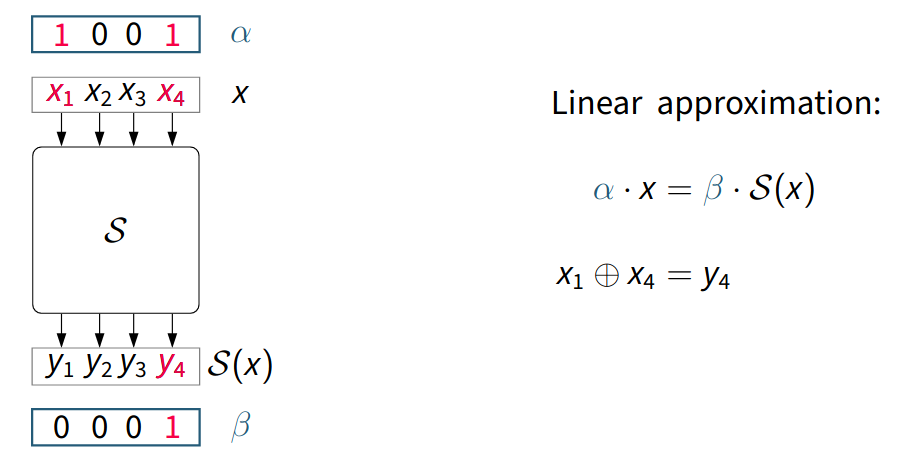

## Approximating non-linear functions by linear functions

**What is a linear function?**
$$x_n + ... + x_0 + a = y_m + ... + y_0 + b \bmod 2$$
We consider linear functions: 0, the input bits alone or any affine transformation between them

**Reminder:** $\oplus = + \bmod 2$ (xor is addition mod 2)

Example: Consider the `and` gate

|x|y| xy| 
|-|-|-|
|0|0|0
|0|1|0
|1|0|0
|1|1|1

We have the following linear functions: $0, x, y, x\oplus y$ and $x\oplus y \oplus 1$

**How do we evaluate good approximations?** -- We will use different metrics
- *Matches* = How many outputs match to the input?
    - $s = |\{x \in \mathbb{F}_2^n \ : \ \alpha \cdot X = \beta \cdot S(X)\}|$
    - Ex: $x$ mathces the `and` function $3$ times. $x\oplus y$ matches once. (Write the tables)
- *Probability* $p = P_X[\alpha \cdot X = \beta \cdot S(X) = \dfrac s {2^b}$
- *Bias* $\epsilon = p - \dfrac 1 2$
    
- *Correlation* $cor = 2 \cdot \epsilon$

Interpretaion of the bias
- How different is from random? Random is right $\dfrac 1 2$ times so we subtract it
- $\epsilon = 0$ -- as good as random
- $\epsilon > 0$ -- good appr
- $\epsilon < 0$ -- bad appr but we can transform it into a good one if we `xor` by 1

In [20]:
# Consider all possible masks and check the results
def count_matches(alpha: int, beta: int, sbox: list, l: int) -> int:
    """
    Counts mathches of input output given 2 masks
    Input
        alpha: {int} -- input mask
        beta: {int} -- output mask
        sbox: {list} -- sbox
        l: {int} -- sbox intput size in bits
    Returns
        {int} -- number of matches
    """
    s = 0
    for x in range(2**l):
        if dot(x, alpha) == dot(sbox[x], beta):
            s += 1
    return s


def linear_approximation_table(sbox: list, l: int) -> list[list[int]]:
    """
    Computes the linear approximation table
    Input
        sbox: {list} -- sbox
        l: {int} -- sbox intput size in bits
    Returns
        {list of lists} -- table
    """
    res = []
    # Iterate through possible masks
    for alpha in range(2**l):
        row = []
        for beta in range(2**l):
            t = count_matches(alpha, beta, sbox, l) - 1 / 2 * (2**l)  # 1<<l is a normalization factor
            row.append(t)
        res.append(row)
    return res

In [11]:
# An sbox
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]

In [18]:
lat = linear_approximation_table(S, 4)

# Prettier print
print(np.matrix(lat).astype(int))

[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -2  0  2  0 -2  4 -2  2  4  2  0 -2  0  2  0]
 [ 0  2 -2  0 -2  0  0  2  2  4  0  2  4 -2 -2  0]
 [ 0  4  2  2 -2  2  0  0  0  0  2 -2 -2 -2  0  4]
 [ 0  0 -2  2  2 -2  0  0 -4  0  2  2  2  2  0  4]
 [ 0 -2  2  0  2  4  0  2 -2  4  0 -2  0  2 -2  0]
 [ 0 -2  0  2  0  2  4  2  2 -4  2  0  2  0 -2  0]
 [ 0  0  0  0  0  4  0 -4  0  0  0  0  4  0  4  0]
 [ 0  0 -2  2 -4  0  2  2 -4  0 -2 -2  0  0  2 -2]
 [ 0 -2 -6  0  0  2 -2  0  2  0  0 -2 -2  0  0  2]
 [ 0 -2  0 -6 -2  0  2  0 -2  0  2  0  0 -2  0  2]
 [ 0  0  0  0  2 -2  2 -2  0  0 -4 -4  2 -2 -2  2]
 [ 0  0  0  0 -2 -2 -2 -2  0  0  4 -4  2  2 -2 -2]
 [ 0 -2  0  2  2  0 -2  0 -2  0  2  0  0 -6  0 -2]
 [ 0  2 -2  0  0  2  2 -4 -2  0  0  2 -2  0 -4 -2]
 [ 0 -4  2  2 -4  0 -2 -2  0  0 -2  2  0  0 -2  2]]


In [17]:
# Let's look at another Sbox (Block cipher companion)
S = [0xF, 0xE, 0xB, 0xC, 0x6, 0xD, 0x7, 0x8, 0x0, 0x3, 0x9, 0xA, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)
print(np.matrix(lat).astype(int))

[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -2  0  2  0 -2  4 -2  2  4  2  0 -2  0  2  0]
 [ 0  2 -2  0 -2  0  0  2  2  4  0  2  4 -2 -2  0]
 [ 0  4  2  2 -2  2  0  0  0  0  2 -2 -2 -2  0  4]
 [ 0  0 -2  2  2 -2  0  0 -4  0  2  2  2  2  0  4]
 [ 0 -2  2  0  2  4  0  2 -2  4  0 -2  0  2 -2  0]
 [ 0 -2  0  2  0  2  4  2  2 -4  2  0  2  0 -2  0]
 [ 0  0  0  0  0  4  0 -4  0  0  0  0  4  0  4  0]
 [ 0  0 -2  2 -4  0  2  2 -4  0 -2 -2  0  0  2 -2]
 [ 0 -2 -6  0  0  2 -2  0  2  0  0 -2 -2  0  0  2]
 [ 0 -2  0 -6 -2  0  2  0 -2  0  2  0  0 -2  0  2]
 [ 0  0  0  0  2 -2  2 -2  0  0 -4 -4  2 -2 -2  2]
 [ 0  0  0  0 -2 -2 -2 -2  0  0  4 -4  2  2 -2 -2]
 [ 0 -2  0  2  2  0 -2  0 -2  0  2  0  0 -6  0 -2]
 [ 0  2 -2  0  0  2  2 -4 -2  0  0  2 -2  0 -4 -2]
 [ 0 -4  2  2 -4  0 -2 -2  0  0 -2  2  0  0 -2  2]]


## Adding the key

Adding the key is simple. 
$$\alpha X \cdot \oplus \kappa \cdot K = \beta \cdot  Y$$

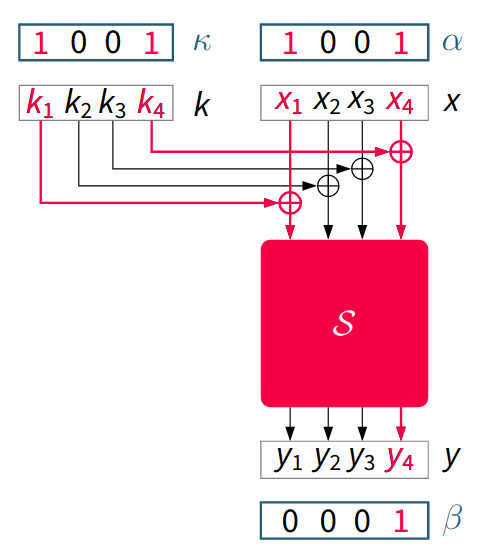

For the masks in the image we have the following equations:
$X_1 \oplus X_4 \oplus K_1 \oplus K_4 = Y_4 \\
X_1 \oplus X_4 \oplus Y_4 = K_1 \oplus K_4 $

Given enough $(X, Y)$ pairs we get some information about the key.

In [21]:
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]
lat = linear_approximation_table(S, 4)

# Investigate the lat
print(np.matrix(lat).astype(int))

[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -4  0 -4  0  0  0  0  0 -4  0  4]
 [ 0  0  2  2 -2 -2  0  0  2 -2  0  4  0  4 -2  2]
 [ 0  0  2  2  2 -2 -4  0 -2  2 -4  0  0  0 -2 -2]
 [ 0  0 -2  2 -2 -2  0  4 -2 -2  0 -4  0  0 -2  2]
 [ 0  0 -2  2 -2  2  0  0  2  2 -4  0  4  0  2  2]
 [ 0  0  0 -4  0  0 -4  0  0 -4  0  0  4  0  0  0]
 [ 0  0  0  4  4  0  0  0  0 -4  0  0  0  0  4  0]
 [ 0  0  2 -2  0  0 -2  2 -2  2  0  0 -2  2  4  4]
 [ 0  4 -2 -2  0  0  2 -2 -2 -2 -4  0 -2  2  0  0]
 [ 0  0  4  0  2  2  2 -2  0  0  0 -4  2  2 -2  2]
 [ 0 -4  0  0 -2 -2  2 -2 -4  0  0  0  2  2  2 -2]
 [ 0  0  0  0 -2 -2 -2 -2  4  0  0 -4 -2  2  2 -2]
 [ 0  4  4  0 -2 -2  2  2  0  0  0  0  2 -2  2 -2]
 [ 0  0  2  2 -4  4 -2 -2 -2 -2  0  0 -2 -2  0  0]
 [ 0  4 -2  2  0  0 -2 -2 -2  2  4  0  2  2  0  0]]


In [23]:
# Pick an entry that is not 0 -> 9-1 => 4 in the LAT
alpha = 0b1001  # 9
beta = 0b0001  # 1
kappa = alpha
print("LAT entry: ", lat[alpha][beta])

X = getrandbits(4)
K = getrandbits(4)
print("X: ", bin(X)[2:].zfill(4))
print("K: ", bin(K)[2:].zfill(4))

Y = S[X ^ K]
K1K4 = dot(X, alpha) ^ dot(Y, beta)

print(K1K4 == get_bit(K, 0, 4) ^ get_bit(K, 3, 4))

LAT entry:  4.0
X:  1111
K:  0100
True


In [24]:
# Let's try more runs
t = 0
tries = 1000
for _ in range(tries):
    X = getrandbits(4)
    K = getrandbits(4)
    Y = S[X ^ K]
    K1K4 = dot(X, alpha) ^ dot(Y, beta)
    t += K1K4 == get_bit(K, 0, 4) ^ get_bit(K, 3, 4)  # Increment if true

print(t / tries)  # clearly a bias and not random

0.732


In [25]:
# Let's look at an entry equal to 0
alpha = 1
beta = 0
print("LAT entry: ", lat[alpha][beta])

t = 0
tries = 1000
for _ in range(tries):
    X = getrandbits(4)
    K = getrandbits(4)
    Y = S[X ^ K]
    K1K4 = dot(X, alpha) ^ dot(Y, beta)
    t += K1K4 == get_bit(K, 0, 4) ^ get_bit(K, 3, 4)  # Increment if true

print(t / tries)  # close to .5 thus random

LAT entry:  0.0
0.511


Let's walk through another example. This one is taken from "Block cipher companion":

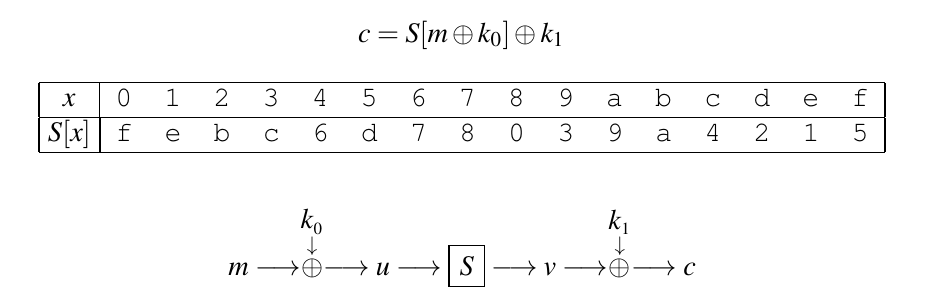

Let 
- $\alpha$ be the mask for $m$
- $\beta$ be the mask for $c$

If we play with the equations we get
- $\alpha \cdot m = \alpha \cdot k_0 \oplus \alpha \cdot u$ - always  (1)  
- $\alpha \cdot u = \beta \cdot v$ - with probability $p$  (2)  
- $\beta \cdot v = \beta \cdot k_1 \oplus \beta \cdot c$ - always  (3)  

By equating (1) with (3) through (2)
- $\alpha \cdot m \oplus \alpha \cdot k_0 = \beta \cdot k_1 \oplus \beta \cdot c \iff \\ 
\alpha \cdot m \oplus \beta \cdot c = \alpha \cdot k_0 \oplus \beta \cdot k_1$
- On the left we have $m, c$ and on the right $k_0, k_1$

In [26]:
S = [0xF, 0xE, 0xB, 0xC, 0x6, 0xD, 0x7, 0x8, 0x0, 0x3, 0x9, 0xA, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)

alpha = 0b1001  # 9
beta = 0b0010  # 2
print("LAT entry: ", lat[alpha][beta])  # [9, 2]

t = 0
tries = 1000
for _ in range(tries):
    m = getrandbits(4)
    k0 = getrandbits(4)
    k1 = getrandbits(4)

    u = m ^ k0
    v = S[u]
    c = v ^ k1

    # lat[alpha][beta] = -6 => we xor with 1
    t += dot(m, alpha) ^ dot(c, beta) ^ 1 == dot(k0, alpha) ^ dot(k1, beta)

print(t / tries)  # clearly biased

LAT entry:  -6.0
0.866


## Adding more SBoxes

Consider the following scenario: 

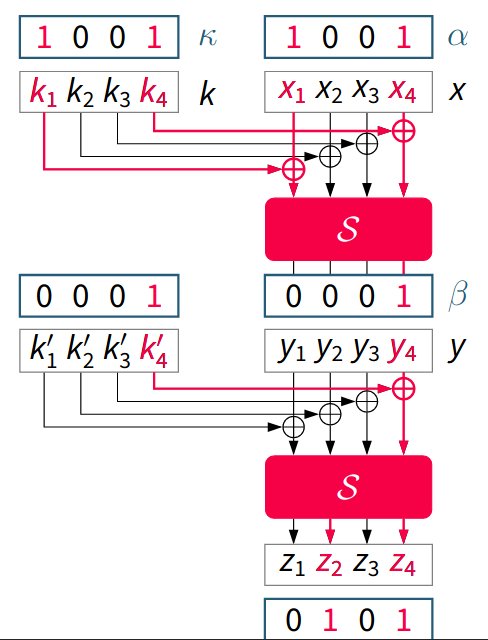

$
\alpha \cdot X \oplus \kappa \cdot K = \beta \cdot Y \\
\beta \cdot y \oplus \kappa' \cdot K' = \gamma \cdot z
$

For this to work we need $\kappa' = \beta$. Otherwise, we use other bits that we don't know anything about. Rewriting:

$
\alpha \cdot X \oplus \kappa \cdot K = \beta \cdot Y \\
\beta \cdot y \oplus \beta \cdot K' = \gamma \cdot z
$

Get some good masks from the table. Equating:

$
X_1 \oplus X_4 \oplus K_1 \oplus K_4 \oplus K'_4 = Z_2 \oplus Z_4 \iff \\
X_1 \oplus X_4 \oplus Z_2 \oplus Z_4 = K_1 \oplus K_4 \oplus K'_4
$


In [27]:
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]
lat = linear_approximation_table(S, 4)

alpha = 0b1001  # 9
kappa = alpha
beta = 0b0001  # 1
gamma = 0b0101  # 5
print("LAT entry alpha beta: ", lat[alpha][beta])  # [9,1]
print("LAT entry beta gamma: ", lat[beta][gamma])  # [1, 5]

t = 0
tries = 1000
for _ in range(tries):
    X = getrandbits(4)
    K = getrandbits(4)
    K_ = getrandbits(4)

    Y = S[X ^ K]
    Z = S[Y ^ K_]

    # lat[alpha][beta] = -6 => we xor with 1
    t += dot(X, alpha) ^ dot(Z, gamma) == dot(K, alpha) ^ dot(K_, beta)

print(t / tries)  # clearly biased

LAT entry alpha beta:  4.0
LAT entry beta gamma:  -4.0
0.381


### Pilling up lemma

The next question arises:  
> If we know the bias of each Sbox approximation, what is the bias of the whole picture? How can we find it?

In [28]:
# Consider the probabilities
p1 = count_matches(alpha, beta, S, 4) / (1 << 4)
p2 = count_matches(beta, gamma, S, 4) / (1 << 4)
print(p1, p2)

0.75 0.25


The approximation is correct if both are "wrong" or "correct". Assuming independence: 
$$
\begin{align*}
p &= \underbrace{p_1 \cdot p_2}_{\text{correct}} + \underbrace{(1 - p_1) \cdot (1 - p_2)}_{\text{wrong}} \iff \\
p &= \dfrac 1 2 + 2 \cdot \epsilon_1 \cdot \epsilon_2
\end{align*}$$

In [29]:
p = p1 * p2 + (1 - p1) * (1 - p2)
print(p)  # Notice that is around what we calculated above

0.375


[**The pilling up lemma**](https://en.wikipedia.org/wiki/Piling-up_lemma)  
Let $X_i$  be **independent** boolean expressions with $p_i = P[X_i = 0] = \dfrac 1 2 + \epsilon_i$. Then we have the following probability:
$$P[X_1 \oplus \dots \oplus X_n = 0] = \dfrac 1 2 + 2^{n-1}\prod_{i=1}^n \epsilon_i$$
Or in bias terms
$$\epsilon_{1,...,n} = 2^{n-1}\prod_{i=1}^n \epsilon_i$$


**Remark**
- Lemma holds, in general, only when random variables are **independent**

In [30]:
def pilling_up_lemma(eps_list):
    n = len(eps_list)
    return 2 ** (n - 1) * np.prod(eps_list)

In [31]:
eps1 = p1 - 1 / 2
eps2 = p2 - 1 / 2
print(eps1, eps2)

p_ = 1 / 2 + 2**1 * np.prod([eps1, eps2])
p_  # It's the same as above

0.25 -0.25


0.375

## Recovering the key

### Matsui 1

This algorithm will give 1 bit of information about the key per linear approximation. Assume we have $\alpha \cdot X \oplus \beta \cdot Y \oplus \kappa \cdot K = 0$ with a positive bias (this means the equation is correct most times)

**Algorithm:**

Input:
- Many Ciphertext / Plaintext pairs

Let
- $T_0, T_1$ - 2 counters

- For each pair $(M_i, C_i)$
    - if $\alpha \cdot M_i \oplus \beta \cdot C_i = 0$ then $T_0++$
    - if $\alpha \cdot M_i \oplus \beta \cdot C_i = 1$ then $T_1++$

- We learn the following
    - If $T_0 > T_1 \Rightarrow \kappa \cdot K = 0$
    - If $T_1 > T_0 \Rightarrow \kappa \cdot K = 1$


**Cons**
- Needs approx of all rounds
- Needs several approximations
- Learns only 1 bit of information. We need more equations to get more bits


**Remark**
- We need around $\dfrac 1 { \epsilon^2}$ messages

In [33]:
def matsui1(M_list: list, C_list: list, alpha: int, beta: int) -> int:
    T0, T1 = 0, 0
    for m, c in zip(M_list, C_list):
        if dot(m, alpha) ^ dot(c, beta) == 0:
            T0 += 1
        else:
            T1 += 1
    if T0 > T1:
        return 0
    else:
        return 1

In [34]:
# Going back to our first example
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]
lat = linear_approximation_table(S, 4)

K = getrandbits(4)
N = 1000

M_list = []
C_list = []
# Generate messages
for _ in range(N):
    M = getrandbits(4)
    C = S[M ^ K]
    M_list.append(M)
    C_list.append(C)

In [35]:
alpha = 0b1001  # 9
beta = 0b0001  # 1
print("LAT entry: ", lat[alpha][beta])

LAT entry:  4.0


In [36]:
K1K4 = dot(K, alpha)

In [37]:
matsui1(M_list, C_list, alpha, beta) == K1K4  # True

True

Let's look at this example from "The block cipher companion":

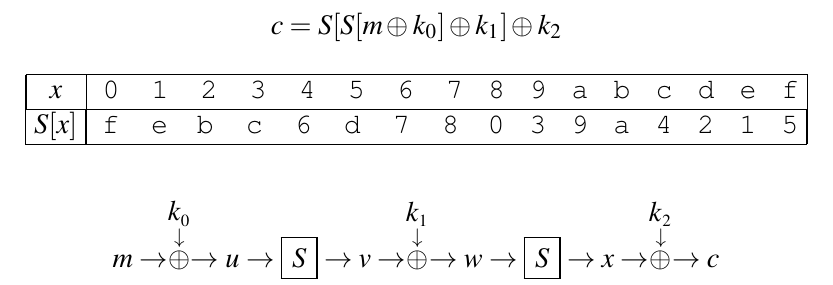

In [38]:
# Generate some ciphertext key pairs
S = [0xF, 0xE, 0xB, 0xC, 0x6, 0xD, 0x7, 0x8, 0x0, 0x3, 0x9, 0xA, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)

M_list, C_list = [], []
N = 100

k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)

for _ in range(N):
    m = getrandbits(4)
    c = S[S[m ^ k0] ^ k1] ^ k2
    M_list.append(m)
    C_list.append(c)

In [39]:
# alpha1 -> S -> alpha2 -> S -> alpha3

# looking at the LAT we see
print(lat[0xD][0xD])  # -6
# Therefore we can use
alpha1 = alpha2 = alpha3 = 0xD

# Attacking
print(matsui1(M_list, C_list, alpha1, alpha3) == dot(k0, alpha1) ^ dot(k1, alpha2) ^ dot(k2, alpha3))

-6.0
True


### Matsui 2

What the first algorithm didn't exploit was how strong the bias is (how different is from 0)

Assume we have an approximation to the first few rounds => we have a bias $\epsilon$ and a lot of message-ciphertext pairs. 
- We can brute force more key bits and decrypt to the bias-known round => $C'$
- If $\alpha \cdot M =  \beta \cdot C'$ increase $T_0$ else increase $T_1$
- The right key will behave similar to the bias. 
    - If we chose a large positive bias then $T_0 \gg T_1$ or reverse
    
   
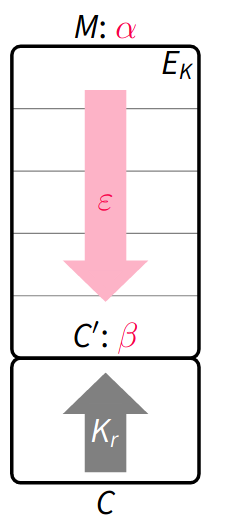

Consider the following cipher from The block cipher companion:

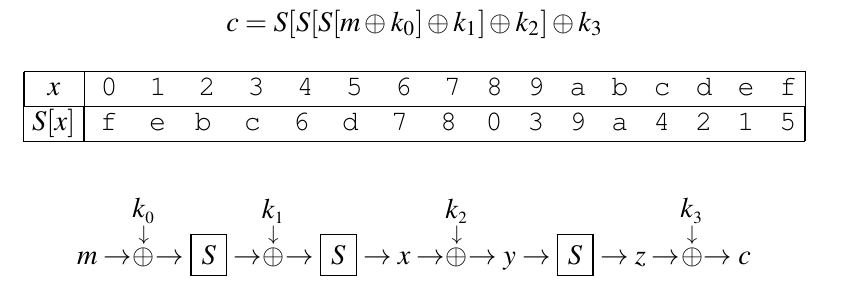

In [40]:
# Generate some ciphertext key pairs
S = [0xF, 0xE, 0xB, 0xC, 0x6, 0xD, 0x7, 0x8, 0x0, 0x3, 0x9, 0xA, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)

M_list, C_list = [], []
N = 1000

k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)
k3 = getrandbits(4)

for _ in range(N):
    m = getrandbits(4)
    c = S[S[S[m ^ k0] ^ k1] ^ k2] ^ k3
    M_list.append(m)
    C_list.append(c)

In [42]:
print(np.matrix(lat).astype(int))

[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -2  0  2  0 -2  4 -2  2  4  2  0 -2  0  2  0]
 [ 0  2 -2  0 -2  0  0  2  2  4  0  2  4 -2 -2  0]
 [ 0  4  2  2 -2  2  0  0  0  0  2 -2 -2 -2  0  4]
 [ 0  0 -2  2  2 -2  0  0 -4  0  2  2  2  2  0  4]
 [ 0 -2  2  0  2  4  0  2 -2  4  0 -2  0  2 -2  0]
 [ 0 -2  0  2  0  2  4  2  2 -4  2  0  2  0 -2  0]
 [ 0  0  0  0  0  4  0 -4  0  0  0  0  4  0  4  0]
 [ 0  0 -2  2 -4  0  2  2 -4  0 -2 -2  0  0  2 -2]
 [ 0 -2 -6  0  0  2 -2  0  2  0  0 -2 -2  0  0  2]
 [ 0 -2  0 -6 -2  0  2  0 -2  0  2  0  0 -2  0  2]
 [ 0  0  0  0  2 -2  2 -2  0  0 -4 -4  2 -2 -2  2]
 [ 0  0  0  0 -2 -2 -2 -2  0  0  4 -4  2  2 -2 -2]
 [ 0 -2  0  2  2  0 -2  0 -2  0  2  0  0 -6  0 -2]
 [ 0  2 -2  0  0  2  2 -4 -2  0  0  2 -2  0 -4 -2]
 [ 0 -4  2  2 -4  0 -2 -2  0  0 -2  2  0  0 -2  2]]


In [43]:
# alpha1 - alpha 2 -> 1st Sbox
# alpha2 - alpha3 -> 2nd Sbox
# alpha3 - alpha4 - > 3rd Sbox

alpha1 = 0b1001  # 9
alpha2 = 0b0010  # 2
alpha3 = 0b1001  # 9
alpha4 = 0b0010  # 2

# or

alpha1 = alpha2 = alpha3 = alpha4 = 0xD

In [44]:
eps1 = count_matches(alpha1, alpha2, S, 4) / (1 << 4) - 1 / 2
eps2 = count_matches(alpha2, alpha3, S, 4) / (1 << 4) - 1 / 2
eps3 = count_matches(alpha3, alpha4, S, 4) / (1 << 4) - 1 / 2
print(eps1, eps2, eps3)

-0.375 -0.375 -0.375


In [45]:
eps = pilling_up_lemma([eps1, eps2])
print(eps)
p = eps + 1 / 2
print(p)  # Therefore we expect `p` correct cases

0.28125
0.78125


In [46]:
1 / eps**2

12.641975308641975

In [53]:
def matsui2(M_list: list, C_list: list, alpha: int, beta: int, S_: list, key_bits: int = 4) -> list:
    """
    Does R-1 key attack
    Input:
        M_list: {list} -- messages
        C_list: {list} -- ciphertext
        alpha: {int} -- input mask
        beta: {int} -- penultimate round mask
        S_: {list} -- Sbox INVERSE
        key_bits: {int}, default=4 -- number of key bits to search through

    Return:
        {list} -- list of differences. Take the max difference for the key
    """
    t_diffs = []
    for k in range(1 << key_bits):  # Iterate through possible keys
        t0, t1 = 0, 0
        for m, c in zip(M_list, C_list):
            # Reverse one round
            c_ = c ^ k
            c_ = S_[c_]
            # Check if the statement is correct
            if dot(m, alpha) == dot(c_, beta):
                t0 += 1
            else:
                t1 += 1
        print(t0, t1)
        t_diffs.append(t0 - t1)
    return t_diffs

In [49]:
k3

10

In [50]:
S_ = inverse_sbox(S)
t_diffs = matsui2(M_list, C_list, alpha1, alpha3, S_)

249 751
491 509
499 501
506 494
634 366
391 609
508 492
268 732
609 391
366 634
732 268
492 508
509 491
751 249
494 506
501 499


In [51]:
np.argmax(t_diffs)

13

In [52]:
np.argsort(np.abs(t_diffs))[::-1]

array([13,  0, 10,  7,  9,  4,  8,  5, 12,  1, 11,  6, 14,  3, 15,  2])

## Bigger block cipher

Let's work on the SPN cipher we defined in the "Design of block ciphers" notebook


In [65]:
# Substitute and permute
# Substitute and permute


def substitute(x: int, sbox: list, l: int) -> int:
    """
    Takes a 2**n bit number x and substitutes n-bit parts according to the n-bit sbox
    Arguments
        x: {int} --  input number of size 2**n bits
        sbox: {Sbox} -- Sbox with input entries of size n bits
        l: {int} -- Sbox input size in bits
    Returns
        {int} -- output sboxed
    """
    word_size = 1 << l
    mask = (1 << l) - 1
    y = 0
    for i in range(0, word_size, l):  # Steps of n-bits
        y = y << l  # Shift 'l' positions to make space for l-bit sbox number
        idx = (x >> (word_size - i - l)) & mask  # Get n-bit index in the sbox
        y = y | sbox[idx]  # "append" the bit from x
    return y


def permute(x: int, pbox: list, n: int) -> int:
    """
    Takes a n-bit int x and permutes the bits from it according to the pbox
    Arguments
        x: {int}  -- n-bit int
        pbox: {list} -- list of integers of length n
        n: int -- number of bits of x
    Return:
        {int}
    """
    y = 0
    for p in pbox:
        y = y << 1  # shift to make space for LSB
        y = y ^ get_bit(x, p, n)  # "append" the p'th bit from x
    return y


class SPN:
    def __init__(self, sbox: list, pbox: list, block_size: int = 16, sbox_input_size: int = 4):
        self.sbox = sbox
        self.sbox_ = inverse_sbox(sbox)
        self.pbox = pbox
        self.block_size = block_size
        self.l = sbox_input_size

    def key_schedule(self, k: int) -> list:
        return [k >> i * 4 & 0xFFFF for i in range(4, -1, -1)]

    def encrypt(self, m: int, k: int) -> int:
        ks = self.key_schedule(k)

        w = m
        for i in range(len(ks) - 2):
            u = w ^ ks[i]
            v = substitute(u, self.sbox, self.l)
            w = permute(v, self.pbox, self.block_size)

        u = w ^ ks[-2]
        v = substitute(u, S, self.l)
        y = v ^ ks[-1]

        return y

    def decrypt(self, c: int, k: int) -> int:

        ks = self.key_schedule(k)

        v = ks[-1] ^ c
        u = substitute(v, self.sbox_, self.l)
        w = ks[-2] ^ u

        for ki in ks[::-1][2:]:
            v = permute(w, self.pbox, self.block_size)
            u = substitute(v, self.sbox_, self.l)
            w = u ^ ki
        return w

We shall follow this path

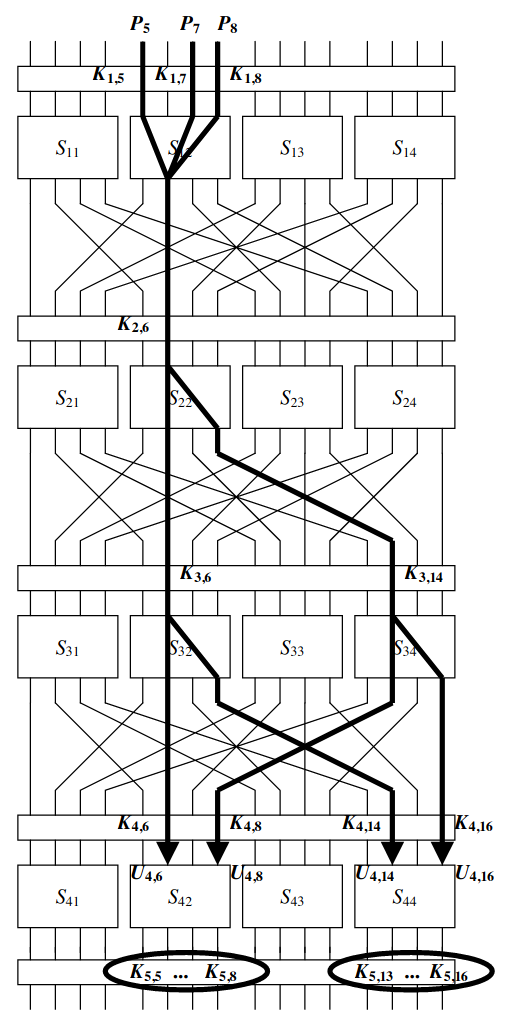

In [54]:
# Sbox and Pbox
S = [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7]
S_ = inverse_sbox(S)
P = [0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]

In [55]:
lat = linear_approximation_table(S, 4)

In [56]:
print(np.matrix(lat).astype(int))

[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -2 -2  0  0 -2  6  2  2  0  0  2  2  0  0]
 [ 0  0 -2 -2  0  0 -2 -2  0  0  2  2  0  0 -6  2]
 [ 0  0  0  0  0  0  0  0  2 -6 -2 -2  2  2 -2 -2]
 [ 0  2  0 -2 -2 -4 -2  0  0 -2  0  2  2 -4  2  0]
 [ 0 -2 -2  0 -2  0  4  2 -2  0 -4  2  0 -2 -2  0]
 [ 0  2 -2  4  2  0  0  2  0 -2  2  4 -2  0  0 -2]
 [ 0 -2  0  2  2 -4  2  0 -2  0  2  0  4  2  0  2]
 [ 0  0  0  0  0  0  0  0 -2  2  2 -2  2 -2 -2 -6]
 [ 0  0 -2 -2  0  0 -2 -2 -4  0 -2  2  0  4  2 -2]
 [ 0  4 -2  2 -4  0  2 -2  2  2  0  0  2  2  0  0]
 [ 0  4  0 -4  4  0  4  0  0  0  0  0  0  0  0  0]
 [ 0 -2  4 -2 -2  0  2  0  2  0  2  4  0  2  0 -2]
 [ 0  2  2  0 -2  4  0  2 -4 -2  2  0  2  0  0  2]
 [ 0  2  2  0 -2 -4  0  2 -2  0  0 -2 -4  2 -2  0]
 [ 0 -2 -4 -2 -2  0  2  0  0 -2  4 -2 -2  0  2  0]]


In [60]:
alpha0 = 0b1011  # 11
alpha1 = 0b0100  # 4
alpha2 = 0b0101  # 5

In [61]:
eps1 = count_matches(alpha0, alpha1, S, 4) / (1 << 4) - 1 / 2
eps2 = count_matches(alpha1, alpha2, S, 4) / (1 << 4) - 1 / 2
eps3 = count_matches(alpha1, alpha2, S, 4) / (1 << 4) - 1 / 2
eps4 = count_matches(alpha1, alpha2, S, 4) / (1 << 4) - 1 / 2
print(eps1, eps2, eps3, eps4)

0.25 -0.25 -0.25 -0.25


In [62]:
eps = pilling_up_lemma([eps1, eps2, eps3, eps4])
print(eps)
print(1 / eps**2)

-0.03125
1024.0


In [63]:
def matsui2_big(M_list: list, C_list: list, alpha: int, beta: int, S_: list, key_bits: list = 8) -> list:
    """
    Does R-1 key attack
    Input:
        M_list: {list} -- messages
        C_list: {list} -- ciphertext
        alpha: {int} -- input mask
        beta: {int} -- penultimate round mask
        S_: {list} -- Sbox INVERSE
        key_bits: {int}, default=4 -- number of key bits to search through

    Return:
    {list} -- list of differences. Take the max difference for the key
    """
    t_diffs = []
    for k in range(1 << key_bits):  # Iterate through possible keys
        k1, k2 = (k >> 4) & 0xF, k & 0xF
        t0, t1 = 0, 0
        for m, c in zip(M_list, C_list):
            # Reverse one round
            c_ = c ^ (k1 << 8) ^ k2
            c_ = substitute(c_, S_, 4)
            # Check if the statement is correct
            if dot(m, alpha) == dot(c_, beta):
                t0 += 1
            else:
                t1 += 1
        # print(t0, t1)
        t_diffs.append(t0 - t1)
    return t_diffs

In [82]:
# Generate (m, c) pairs

spn = SPN(S, P)
K = getrandbits(48)
Ks = spn.key_schedule(K)

N = 10000
M_list = []
C_list = []
for _ in range(N):
    m = getrandbits(16)
    c = spn.encrypt(m, K)
    M_list.append(m)
    C_list.append(c)

In [83]:
t_diffs = matsui2_big(M_list, C_list, 0x0B00, 0x0505, S_)

In [84]:
(Ks[-1] & 0xF00) >> 8, Ks[-1] & 0xF

(14, 0)

In [85]:
kk = np.argsort(np.abs(t_diffs))[::-1]

# Take first key
for key in kk[:1]:
    print(key, (key & 0xF0) >> 4, key & 0xF)

224 14 0


## Defense against linear cryptanalysis

# Resources
- https://www.youtube.com/watch?v=RE6xu5THyJA&list=PLfX_2xRB__0OhOzA-rl6kvnLCCtrRoS7x&index=9 - very good explanation
- https://www.youtube.com/watch?v=1BU_fG8j51w
- http://www.cs.bc.edu/~straubin/crypto2017/heys.pdf
- https://marc-stevens.nl/research/mastermath/2015/cryptanalysis_notes_ch8_v1.pdf
- The block cipher companion
- Cryptography Theory and practice